# Pre requisites

In [1]:
import cv2

In [2]:
# Import standard dependencies
import os
import random
import numpy as np

from matplotlib import pyplot as plt

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

### tf.data.Dataset

The `tf.data.Dataset` API supports writing descriptive and efficient input pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

The simplest way to create a dataset is to create it from a python `list`

In [5]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    data_types.DatasetV2,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dty

In [6]:
# Represents a potentially large set of elements.

anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [138]:
# Now we have a DATA PIPELINE 
# A way to iterate over all the data points in a dir

dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\07aab84e-209f-11ef-a43b-f21805e91111.jpg'


## 3.2 Preprocessing - Scale and Resize

In [8]:
def pre_process(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100 x 100 x 3 <--- size of 100 x 100 and ALL 3 channel
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 <------------------------------ Remember the optimisation that in GD for LinReg
    img = img / 255.0
    
    # Return image
    return img

- def pre_process()
- dataset.map( pre_process )
> applies pre_process fn to each data_label of dataset


- [ ] tf.io.decode_jpeg() docmentation is interesting ; there is a way to downscale WHILE DECODING , but only  by 2,4,8 ; Try Downscaling by 255 



In [9]:
tf.io.decode_jpeg??

Signature:
tf.io.decode_jpeg(
    contents: Annotated[Any, <class 'tensorflow.security.fuzzing.py.annotation_types.String'>],
    channels: int = 0,
    ratio: int = 1,
    fancy_upscaling: bool = True,
    try_recover_truncated: bool = False,
    acceptable_fraction: float = 1,
    dct_method: str = '',
    name=None,
) -> Annotated[Any, <class 'tensorflow.security.fuzzing.py.annotation_types.UInt8'>]
Source:   
def decode_jpeg(contents: Annotated[Any, _atypes.String], channels:int=0, ratio:int=1, fancy_upscaling:bool=True, try_recover_truncated:bool=False, acceptable_fraction:float=1, dct_method:str="", name=None) -> Annotated[Any, _atypes.UInt8]:
  r"""Decode a JPEG-encoded image to a uint8 tensor.

  The attr `channels` indicates the desired number of color channels for the
  decoded image.
  
  Accepted values are:
  
  *   0: Use the number of channels in the JPEG-encoded image.
  *   1: output a grayscale image.
  *   3: output an RGB image.
  
  If needed, the JPEG-encoded imag

In [10]:
byte_img = tf.io.read_file('data\\anchor\\334093f9-209f-11ef-94fe-f21805e91111.jpg')
img_decoded = tf.io.decode_jpeg(byte_img)
img_resized = tf.image.resize(img_decoded, (100,100) )
img_scaled_down = img_resized / 255.0

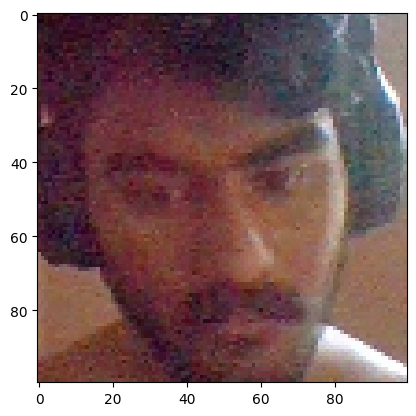

In [11]:
# plt.imshow(img_resized) does not work as the img_resized in a tensor ( not a numpy library )
# plt.imshow(img_resized.numpy()) 
plt.imshow(img_resized.numpy().astype(np.uint8) ) 

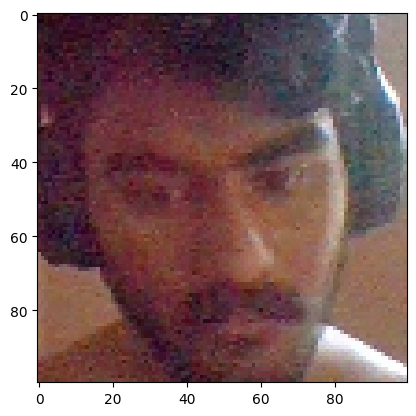

In [12]:
plt.imshow(img_scaled_down)

### Are these two the same image (or) Comparing Images

Finding if two images are equal with `Opencv`, is a quite simple operation.

There are 2 fundamental elements to consider:

1. The images have both the `same size` and `channels`
2. Each `pixel` has the `same value`

- If they have the `same sizes and channels`, then `SUBTRACT`. 
- The operation cv2.subtract(image1, image2) simply subtract from each pixel of the first image, the value of the corresponding pixel in the second image.
- A `colored image` has `3 channels (blue, green, and red)`
- The `cv2.subtract()` operation makes the subtraction `for every single channel` and we need to check if all the three channels are black.

In [13]:
im_resz_shape = img_resized.numpy().shape
im_scale_shape = img_scaled_down.numpy().shape
print(f'Same size and channels = { im_scale_shape == im_resz_shape} ; scaled_down = { im_scale_shape } ; resize = {im_resz_shape}')

Same size and channels = True ; scaled_down = (100, 100, 3) ; resize = (100, 100, 3)


In [14]:
difference = cv2.subtract(img_resized.numpy() , img_scaled_down.numpy())
b, g, r = cv2.split(difference)
if cv2.countNonZero(b) == 0 and cv2.countNonZero(g) == 0 and cv2.countNonZero(r) == 0:
    print("The images are completely Equal")
else:
    print("The images are different")

The images are different


<font size="5"> => So they are indeed Different ; Learnt something about processing images in cv2 </font>

In [15]:
# What exactly is the difference ?

# print(b, g, r)
# plt.imshow(difference.astype(np.uint8)  ) # <----- this is insane ; WHY DOES DIFFERENCE image ALSO LOOK THE SAME, you woul expect a black image

## 3.3 Create Labelled Dataset

In [16]:
anchor??

Type:           _TakeDataset
String form:    <_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Length:         300
File:           c:\users\hp\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages\tensorflow\python\data\ops\take_op.py
Source:        
class _TakeDataset(dataset_ops.UnaryUnchangedStructureDataset):
  """A `Dataset` containing the first `count` elements from its input."""

  def __init__(self, input_dataset, count, name=None):
    """See `Dataset.take()` for details."""
    self._input_dataset = input_dataset
    self._count = ops.convert_to_tensor(count, dtype=dtypes.int64, name="count")
    self._name = name
    variant_tensor = gen_dataset_ops.take_dataset(
        input_dataset._variant_tensor,  # pylint: disable=protected-access
        count=self._count,
        **self._common_args)
    super().__init__(input_dataset, variant_tensor)
Init docstring: See `Dataset.take()` 

## Important TensorFlow `Dataset` Operations

### tf.data.Dataset.zip

Creates a `Dataset` by zipping together the given datasets.```

    This method has similar semantics to the built-in `zip()` function
    in Python, with the main difference being that the `datasets`
    argument can be a (nested) structure of `Dataset` objects. The supported
    nesting mechanisms are documented
    [here] (https://www.tensorflow.org/guide/data#dataset_structure).

    >>> # The datasets or nested structure of datasets `*args` argument
    >>> # determines the structure of elements in the resulting dataset.
    >>> a = tf.data.Dataset.range(1, 4)  # ==> [ 1, 2, 3 ]
    >>> b = tf.data.Dataset.range(4, 7)  # ==> [ 4, 5, 6 ]
    >>> ds = tf.data.Dataset.zip(a, b)
    >>> list(ds.as_numpy_iterator())
    [(1, 4), (2, 5), (3, 6)]
    >>> ds = tf.data.Dataset.zip(b, a)
    >>> list(ds.as_numpy_iterator())
    [(4, 1), (5, 2), (6, 3)]
    >>>
    >>> # The `datasets` argument may contain an arbitrary number of datasets.
    >>> c = tf.data.Dataset.range(7, 13).batch(2)  # ==> [ [7, 8],
    ...                                            #       [9, 10],
    ...                                            #       [11, 12] ]
    >>> ds = tf.data.Dataset.zip(a, b, c)
    >>> for element in ds.as_numpy_iterator():
    ...   print(element)
    (1, 4, array([7, 8]))
    (2, 5, array([ 9, 10]))
    (3, 6, array([11, 12]))
    >>>
    >>> # The number of elements in the resulting dataset is the same as
    >>> # the size of the smallest dataset in `datasets`.
    >>> d = tf.data.Dataset.range(13, 15)  # ==> [ 13, 14 ]
    >>> ds = tf.data.Dataset.zip(a, d)
    >>> list(ds.as_numpy_i```e the same first
        dimension. Supported values are documented
erator())
    [(1, 13), (2, 14)]

tf.data.Dataset.from_tensor_slices

### tf.data.Dataset.from_tensor_slices

Creates a `Dataset` whose elements are slices of the given tensors.

    The given tensors are sliced along their first dimension. This operation
    preserves the structure of the input tensors, removing the first dimension
    of each tensor and using it as the dataset dimension. All input tensors
    must have the same size in their first dimensions.

    >>> # Slicing a 1D tensor produces scalar tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
    >>> list(dataset.as_numpy_iterator())
    [1, 2, 3]

    >>> # Slicing a 2D tensor produces 1D tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
    >>> list(dataset.as_numpy_iterator())
    [array([1, 2], dtype=int32), array([3, 4], dtype=int32)]

### This is INSANELY USEFUL

    >>> # Two tensors can be combined into one Dataset object.
    >>> features = tf.constant([[1, 3], [2, 1], [3, 3]]) # ==> 3x2 tensor
    >>> labels = tf.constant(['A', 'B', 'A']) # ==> 3x1 tensor
    >>> dataset = Dataset.from_tensor_slices((features, labels))
    >>> # Both the features and the labels tensors can be converted
    >>> # to a Dataset object separately and combined after.
    >>> features_dataset = Dataset.from_tensor_slices(features)
    >>> labels_dataset = Dataset.from_tensor_slices(labels)
    >>> dataset = Dataset.zip((features_dataset, labels_dataset))
   
    >>> # A batched feature and label set can be converted to a Dataset in similar fashion.
    >>> batched_features = tf.constant([[[1, 3], [2, 3]],
    ...                                 [[2, 1], [1, 2]],
    ...                                 [[3, 3], [3, 2]]], shape=(3, 2, 2))    <----- 3 x 3 Tensor ; each element has 2 elements 
    >>> batched_labels = tf.constant([['A', 'A'],
    ...                               ['B', 'B'],
    ...                               ['A', 'B']], shape=(3, 2, 1))
    >>> dataset = Dataset.from_tensor_slices((batched_features, batched_labels))
    >>> for element in dataset.as_numpy_iterator():
    ...   print(element)
    (array([[1, 3],
           [2, 3]], dtype=int32), array([[b'A'],
           [b'A']], dtype=object))
    (array([[2, 1],
           [1, 2]], dtype=int32), array([[b'B'],
           [b'B']], dtype=object))
    (array([[3, 3],
           [3, 2]], dtype=int32), array([[b'A'],
           [b'B']], dtype=object))

### Tricky Cases that I do not understand :-

    >>> # Slicing a tuple of 1D tensors produces tuple elements containing
    >>> # scalar tensors.
    >>> dataset = tf.data.Dataset.from_tensor_slices(([1, 2], [3, 4], [5, 6]))
    >>> list(dataset.as_numpy_iterator())
    [(1, 3, 5), (2, 4, 6)]

    >>> # Dictionary structure is also preserved.
    >>> dataset = tf.data.Dataset.from_tensor_slices({"a": [1, 2], "b": [3, 4]})
    >>> list(dataset.as_numpy_iterator()) == [{'a': 1, 'b': 3},
    ...                                       {'a': 2, 'b': 4}]
    True
    
    
    Note that if `tensors` contains a NumPy array, and eager execution is not
    enabled, the values will be embedded in the graph as one or more
    `tf.constant` operations. For large datasets (> 1 GB), this can waste
    memory and run into byte limits of graph serialization. If `tensors`
    contains one or more large NumPy arrays, consider the alternative described
    in [this guide](
    https://tensorflow.org/guide/data#consuming_numpy_arrays).

    Args:
      tensors: A dataset element, whose components have the same first
        dimension. Supported values are documented


## Code for Dataset Labelling

In [17]:
tf.ones_like( [1,2,3] ) # this creates an np array of [1,1,1]

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 1, 1])>

In [18]:
tf.ones( 10 ) 

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [19]:
 tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [20]:
 tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>

In [21]:
# Now we have anchor, negative, positive as tensorflow DATASET ( pipeliend and organised data )

# We want to Label certain (X,Y) as 1 ; certain (X,Y) as 0 ;

# (anchor, positive) => 1,1,1,1,1  i.e positives 
# (anchor, negative) => 0,0,0,0,0  i.e negatives

# SO WE create ( anchor , +/- , 1/0 ) labels ; WE ZIP 

<font size="5"> WE ZIP TOGETHER ENTIRE DATASET INTO JUST 2 THINGS :- </font>
<font size="5">  <ol>  <li>( ANCHOR , POSITIVE , 1 )s  <li>( ANCHOR , NEGETIVE , 0 )s </ol>  </font>
<font size="5">  And we finally concatenate both of them to have a SINGLE DATASET </font>

In [22]:
positives = tf.data.Dataset.zip( (anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))   )

# positives = tf.data.Dataset.zip( (anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones_like(anchor))   )
negatives = tf.data.Dataset.zip( (anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))  )

data = positives.concatenate(negatives)

In [23]:
samples_1 = data.as_numpy_iterator()

In [24]:
example = samples_1.next()
example

(b'data\\anchor\\f7214dfa-209e-11ef-a7f6-f21805e91111.jpg',
 b'data\\positive\\ba417d56-209f-11ef-864d-f21805e91111.jpg',
 1.0)

<font size="5"> `*example` we can PASS UN-PACK THE ZIPPED IN DATA really EASILY to FUNCTIONS'  </font>

#### Learn Later this ( what differenciates you from the rest ) 

> Useful Snippet

In [25]:
# Create tf DATASETS
zero_labels     = tf.data.Dataset.from_tensor_slices( tf.zeros( len(anchor) ) )
numbers         = tf.data.Dataset.range(10)

# convert to numpy iterator
iterator_labels_zero   = zero_labels.as_numpy_iterator()
iterator_labels_number = numbers.as_numpy_iterator()

# this is a nice way to see 
list( iterator_labels_zero )  
list( iterator_labels_number )   

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#### tf.ones() and tf.ones_like()

In [26]:
# this example is bugged out ; But I was trying to write the same thing in different way ( using ones and ones_like )


# anchor_test = [[1, 2], [3, 4]]
# positive_test = [[5, 6], [7, 8]]  # Example data

# positives_test_using_ones = tf.data.Dataset.zip((anchor_test, positive_test, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor_test)))))

# positives_test_using_ones_like = tf.data.Dataset.zip((anchor_test, positive_test, tf.data.Dataset.from_tensor_slices(tf.ones_like(anchor_test))) )


# for item in positives_test_using_ones:
#     print(item)
# print("---------------------")


# for item in positives_test_using_ones_like:
#     print(item)
# print("---------------------")


## 3.4 Build Train and Test Partition

In [27]:
def pre_process_together(input_img, validation_img, label):
    return(pre_process(input_img), pre_process(validation_img), label)

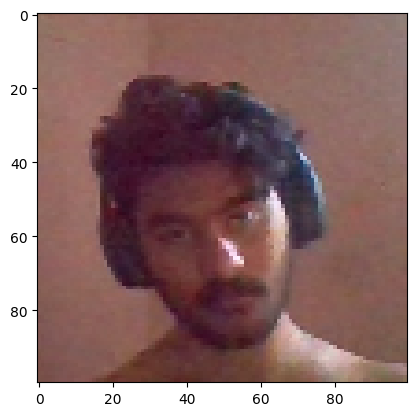

In [28]:
## THIS IS SOO COOL

example = samples_1.next()
res = pre_process_together(*example)   # UNPACKING IN STYLE !!!

# res is just a tuple of ( anchor, +/-, 1 ) 
plt.imshow(res[0])

#### Data Loader Pipelines ; Caches ; Batching and Splitting into TRAIN and TEST

In [29]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [30]:
## THIS CELL TAUGHT ME AN IMPORTANT LESSON

# Build dataloader pipeline
data_cleaned        = data.map(pre_process_together)
data_cleaned_cached = data_cleaned.cache()
data_final          = data_cleaned_cached.shuffle(buffer_size=1024)


sample_data_to_iterate_on = data_final.as_numpy_iterator()
sample = sample_data_to_iterate_on.next()[0]
sample
# plt.imshow(sample)
# plt.imshow(sample[1])

array([[[0.5879902 , 0.45465687, 0.4154412 ],
        [0.59411764, 0.4490196 , 0.41470587],
        [0.6002451 , 0.4492647 , 0.42083332],
        ...,
        [0.5997549 , 0.5330882 , 0.5056372 ],
        [0.59705883, 0.53039217, 0.5029412 ],
        [0.59705883, 0.53039217, 0.5029412 ]],

       [[0.6009804 , 0.46764705, 0.42647058],
        [0.59117645, 0.45784312, 0.41715688],
        [0.59632355, 0.45416668, 0.42009804],
        ...,
        [0.59460783, 0.5203431 , 0.50735295],
        [0.58259803, 0.5120098 , 0.4982843 ],
        [0.5872549 , 0.52843136, 0.5107843 ]],

       [[0.6039216 , 0.4735294 , 0.41764706],
        [0.6041667 , 0.4715686 , 0.41838235],
        [0.60539216, 0.4639706 , 0.41960785],
        ...,
        [0.5862745 , 0.50980395, 0.5107843 ],
        [0.5764706 , 0.5058824 , 0.50392157],
        [0.5735294 , 0.5117647 , 0.5088235 ]],

       ...,

       [[0.5323529 , 0.38137254, 0.33333334],
        [0.53333336, 0.38431373, 0.33333334],
        [0.54093134, 0

<font size="5">  VERY IMPORTANT LESSON :- WHEN TO SPLIT CELLS </font>
> There are places where we can run a cell ONLY A SINGLE TIME ; 
```js
// Build dataloader pipeline
data = data.map(pre_process_together)
data = data.cache()
data = data.shuffle(buffer_size=1024)
```
=> You can't keep on Running the above cell ; sine the output `data` variable is not the input `data` variable

sample_data_to_iterate_on = data_final.as_numpy_iterator()
sampe = sample_data_to_iterate_on.next()[0]

In [31]:
# RUN THIS CELL ONLY ONCE ; BUT RUN THE NEXT CELL HOW MUHC EVER TIMES YOU WANT


# Build dataloader pipeline

data = data.map(pre_process_together)
data = data.cache()
data = data.shuffle(buffer_size=1024)

0.0


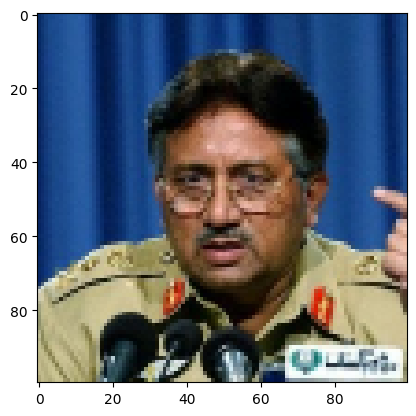

In [98]:
sample_data_to_iterate_on = data.as_numpy_iterator()
sample = sample_data_to_iterate_on.next()  # sample is randomised `data` => Just many ( anchor , pos/neg , 1/0 ) 
sample[0]  # just anchor_image
print(sample[2])  # this is label 0 or 1
plt.imshow(sample[1])  # could be pos or neg

In [33]:
round(len(data)*.7)

420

In [34]:
# Training partition ( we'll take FIRST 70% of the data to train the model )

train_data = data.take(round(len(data)*.7))
# train_data = data.take(420)

# we take batches of 16 images AT A TIME => there are 420 / 16 => 26 batches + 4 images left
train_data = train_data.batch(16)

# THIS STARTS TRAINING NEXT 8 IMAGES WHILE WE ARE PROCESSING 8 IMAGES 
# Just like pipe_lined contorl flow 
train_data = train_data.prefetch(8)

In [35]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

- Note : Data had the shape = ( 100, 100, None )
    1. => inp=100x100 verif=100x100 label=1
    2. => inp = 100 elem ; veri = 100 elem ; label is single scalar 

In [36]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

- Note : TrainData has the shape = ( None, 100, 100, None )
  1. First element is the BATCH_NUMBER
  2. Rest everything is same

In [37]:
iterator = train_data.as_numpy_iterator()
len(iterator.next())      # 3
len(iterator.next()[0])   # 16

16

In [38]:
# Testing partition
test_data = data.skip(round(len(data)*.7))

# remaing shuffeled data is for TESTING ( evaluating )
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

Build a function to make EMBEDDING LAYER :-
```py
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    
    # RETURNS A MODEL
    return Model(inputs= , outputs= , name = )
```


In [39]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

- We are gonna repeat this pattern => Input ->
Conv2d -> MaxPool
->Conv2d -> MaxPool -> 
->Conv2d -> MaxPool -> ...
- We are gonna try to replicate the EXACT MODEL proposed in the paper ; change the input size to 100x100 later

In [40]:
inp = Input(shape=(105,105,3), name='input_image_layer_1') 
# the shape ( None, 100 , 100 , 3) <--- first None is for batch size 
inp

<KerasTensor shape=(None, 105, 105, 3), dtype=float32, sparse=None, name=input_image_layer_1>

In [41]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
c1

<KerasTensor shape=(None, 96, 96, 64), dtype=float32, sparse=False, name=keras_tensor>

In [42]:
# this takes a 2x2 matrix and returns it's maximum
# todo :- the padding='same' parameter, this ensures that we get the same output size
m1 = MaxPooling2D(64, (2,2), padding='same')(c1) 
m1

<KerasTensor shape=(None, 48, 48, 64), dtype=float32, sparse=False, name=keras_tensor_1>

In [43]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
c2

<KerasTensor shape=(None, 42, 42, 128), dtype=float32, sparse=False, name=keras_tensor_2>

In [44]:
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
m2

<KerasTensor shape=(None, 21, 21, 128), dtype=float32, sparse=False, name=keras_tensor_3>

In [45]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
c3

<KerasTensor shape=(None, 18, 18, 128), dtype=float32, sparse=False, name=keras_tensor_4>

In [46]:
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
m3

<KerasTensor shape=(None, 9, 9, 128), dtype=float32, sparse=False, name=keras_tensor_5>

In [47]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
c4

<KerasTensor shape=(None, 6, 6, 256), dtype=float32, sparse=False, name=keras_tensor_6>

In [48]:
f1 = Flatten()(c4)
f1

<KerasTensor shape=(None, 9216), dtype=float32, sparse=False, name=keras_tensor_7>

In [49]:
d1 = Dense(4096, activation='sigmoid')(f1)
d1

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_8>

In [99]:
model = Model(inputs=[inp], outputs=[d1], name='embedding')
model.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image_layer_1 (InputLayer)     │ (None, 105, 105, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 96, 96, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 42, 42, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 18, 18, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='EMBEDDING_01')

In [52]:
embedding = make_embedding()
embedding.summary()

Model: "EMBEDDING_01"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

WE BUILD OUR OWN  <font size=5 >CUSTOM LAYER TO IMPLEMENT OUR IDEA </font>

In [101]:
# Siamese L1 Distance class : THE LAST LAYER BEFORE PASSING TO ANOTHER SIGMOID ;
# THE MOST IMPORTANT PART

class L1Dist(Layer):
    
    # Init method - inheritance
    # kwargs allows us to use abstract methodes and stuff 
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation ; WHENEVER YOU CALL this class ?
    # tdo :- is call() a special function like the one in JAVA
    
    # def call(self, input_embedding, validation_embedding):
    def call(self, input_embedding, validation_embedding):
        
        # input_embedding      = tf.convert_to_tensor(input_embedding)
        # validation_embedding = tf.convert_to_tensor(validation_embedding)
        
        # # Remove potential first dimension
        # input_embedding      = tf.squeeze(input_embedding, axis=0)  
        # validation_embedding = tf.squeeze(validation_embedding, axis=0)
        
        return tf.math.abs(input_embedding - validation_embedding)

In [54]:
l1 = L1Dist()
l1

<L1Dist name=l1_dist, built=False>

## 4.3 Make Siamese Model

In [102]:
input_image = Input(name='input_img', shape=(100,100,3))
input_image

<KerasTensor shape=(None, 100, 100, 3), dtype=float32, sparse=None, name=input_img>

In [56]:
embedding(input_image) # embedding is a MODEL that was output of the make_embedding function

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_18>

In [57]:
siamese_layer_1 = L1Dist()(
                    embedding(Input(shape=(100,100,3))) ,
                    embedding(Input(shape=(100,100,3))) ,
                        )
siamese_layer_1

<KerasTensor shape=(None, 4096), dtype=float32, sparse=False, name=keras_tensor_23>

In [103]:
def integrated_complete_model(): 

    # Handle Input()
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))

    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    # embedding gives a model, i.e we get 2 MODEL ; Is it Model(...output of embdedding fn...)(input_image)
    input_model = embedding(input_image)
    valid_model = embedding(validation_image)
    distances = siamese_layer( input_model , valid_model )
    
    # Classification layer : THE LAST STEP :- passing the distance output to a sigmoid to determine 1 or 0
    classifier = Dense(1, activation='sigmoid')(distances)

    
    return Model(
            inputs=[input_image, validation_image], 
            outputs=classifier, 
            name='SiameseNetwork'
                )


In [68]:
siamese_model = integrated_complete_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ EMBEDDING_01 (Functional)     │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_4 (L1Dist)            │ (None, 4096)              │               0 │ EMBEDDING_01[7][0],        │
│                               │                           │                 │ EMBEDDING_01[8][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_4[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [65]:
## https://keras.io/api/optimizers/

# defining the optimizer used
opt = tf.keras.optimizers.Adam(learning_rate = 1e-4)  # 0.0001

## 5.2 Establish Checkpoints

In [106]:
checkpoint_dir = './training_checkpoints'
# we define the prefix attached to each name
checkpoint_prefix = os.path.join(checkpoint_dir, 'CHECKPOINT_')


checkpoint = tf.train.Checkpoint(opt=opt, integrated_complete_model=integrated_complete_model() )

## 5.3 Build Train Step Function
- this is done on <font size=4>ONE BATCH OF DATA</font> 
- The basic workflow is :-
    1. Make Prediction
    2. Calculate Loss
    3. Derive Gradients
    4. Calculate new weights and apply
- This is done on ONE BATCH of data

In [131]:
test_batch = train_data.as_numpy_iterator()

In [123]:
# ( 16 anchor ; 16 +/- ; 16 labels i.e 0s and 1s  )
batch_1 = test_batch.next()

# 3
len(batch_1)    

3

In [115]:
# uncommnet and execute for each

len(batch_1[1])
len(batch_1[0])
len(batch_1[2])

16

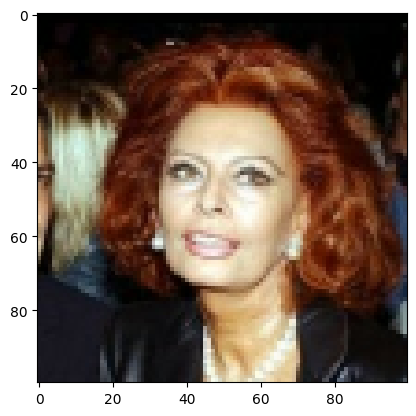

In [134]:
# 16 validation images
x = batch_1[1] 
first_of_16_validation_image_in_the_batch_1 = x[0]
plt.imshow(first_of_16_validation_image_in_the_batch_1)

In [110]:
# all 16 labels corresponding to each of the ( 16 anchors , 16 validaiton ) 
y = batch_1[2]
y

array([1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
      dtype=float32)

<font size=6>THIS IS INSANE </font>
> we have A SET OF 2 elemts each being- 16 images, each being 100 x 100 pixels across 3 different channels

In [122]:
# we get the pairs 
X = batch_1[0:2] 

# X was a list ; we converted to a numpy_array so that we can use .shape
np.array(X).shape

# It's 5 DIMENSIONAL DATA !!!!!!
# => we have pair of 16 images, each being 100 x 100 pixels across 3 different channels

(2, 16, 100, 100, 3)

In [125]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [135]:
# we are WRAPPING THIS FUNCTION inside this tf.function 
# whenever we have a function that is OUTSIDE the library we need to use this decorator

# CUSTOM TRAIN_STEP 

# WE RUN this function FOR EACH EPOCH : 
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass 
        # Certain Layers are ONLY GONNA activate once you have training = true
        # yhat = integrated_complete_model()(X, training=True) <---- is this same as below ?
        yhat = siamese_model(X, training=True)
        
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

## 5.4 Build Training Loop

In [136]:
# we pass the 
def train(training_data, EPOCHS):
    
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(training_data))
        
        # Loop through each batch ; TRAINING EACH BATCH
        for idx, batch in enumerate(training_data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [137]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step

 Epoch 15/50
27/27 ━━━━━━━━━━━━━━━

## 6 Evaluate Model
### 6.1 Important Metrics